# How does neighbor density relate to likelihoods ?

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('../peptidome.mplstyle')
#plt.style.use('talk')

import sys
sys.path.append('..')

from lib import *

## check summation formula

In [3]:
def neighbors(sigma, S):
    for i in range(len(sigma)):
        for s in range(S):
            if not sigma[i] == s:
                yield np.asarray(list(sigma[:i]) + [s] + list(sigma[i+1:]))

S = 2
k = 2
sigma_lognormal = 1.0
pi = np.random.lognormal(sigma=sigma_lognormal, size=S)
pi /= pi.sum()
sigma = np.random.randint(0, S, k)
nsigma = np.prod(pi[sigma])*(np.sum(1/pi[sigma]) - k)
nsigma_sum = np.sum(np.fromiter((np.prod(pi[sigmap]) for sigmap in neighbors(sigma, S)), np.float))
print(nsigma, nsigma_sum)

0.3439384511191594 0.3439384511191593


## correlation between probabilities

In [4]:
S = 20
k = 10
sigma = 0.3
pi = np.random.lognormal(sigma=sigma, size=S)
pi /= pi.sum()
psigmas = []
psigmaps = []
Nsample = 10000
for i in range(Nsample):
    sigma = np.random.randint(0, S, k)
    psigma = np.prod(pi[sigma])
    i = np.random.randint(0, k)
    sigmai = np.random.choice([s for s in range(0, S) if s != sigma[i]])
    sigmap = np.asarray(list(sigma[:i]) + [sigmai] + list(sigma[i+1:]))
    psigmap = np.prod(pi[sigmap])
    psigmas.append(psigma)
    psigmaps.append(psigmap)
psigmaps = np.asarray(psigmaps)
psigmas = np.asarray(psigmas)

Text(0, 0.5, "$\\log_{10} p(\\sigma')$")

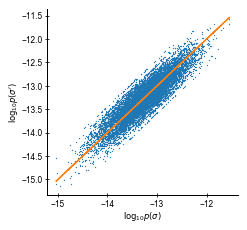

In [5]:
fig, ax = plt.subplots(figsize=(3.42, 3.42))
trans = np.log10
ax.plot(trans(psigmas), trans(psigmaps), '.', label='data', ms=1)
ax.plot(trans(psigmas), trans(psigmas), '-', label='linear')
ax.set_xlabel('$\log_{10} p(\sigma)$')
ax.set_ylabel("$\log_{10} p(\sigma')$")

In [6]:
rhop = np.corrcoef(psigmaps, psigmas)[0, 1]
rhop, np.corrcoef(np.log(psigmaps), np.log(psigmas))[0, 1]

(0.8432573033820352, 0.8950549164412782)

## generate samples from P_uniform(psigma, nsigma)

In [7]:
df = Counter(human, 1).to_df(norm=True, clean=True)
paa = np.asarray(df['freq'])
paa

array([0.02132759, 0.06577845, 0.07012693, 0.06314819, 0.09970845,
       0.08332527, 0.01217275, 0.05643573, 0.05963846, 0.07101057,
       0.02662735, 0.02305051, 0.05347764, 0.0473157 , 0.05724314,
       0.04330068, 0.04767035, 0.02626757, 0.0365297 , 0.03584496])

In [8]:
S = 20
k = 9

Nn = k*(S-1)
N = float(S**k)

#sigma_lognormal = 0.4
#pi = np.random.lognormal(sigma=sigma_lognormal, size=S)
pi = paa
#pi = np.random.uniform(size=S)
pi /= pi.sum()


psigmas = []
nsigmas = []
Nsample = 10000
for i in range(Nsample):
    sigma = np.random.randint(0, S, k)
    psigma = np.prod(pi[sigma])
    nsigma = np.prod(pi[sigma])*np.sum((1-pi[sigma])/pi[sigma])
    psigmas.append(psigma)
    nsigmas.append(nsigma)
nsigmas = np.asarray(nsigmas)
psigmas = np.asarray(psigmas)
rho = np.corrcoef(psigmas, nsigmas)[1, 0]
print(r'$\rho_{p(\sigma), n(\sigma)}$:', rho)

$\rho_{p(\sigma), n(\sigma)}$: 0.991705622487347


In [9]:
# variance of lognormal
np.var(np.log(psigmas)), np.var(np.log(pi))*k

(2.3464343858318664, 2.373654150098714)

In [10]:
# coefficient of variation
sigmasq = np.var(np.log(pi))*k
np.var(psigmas)*N**2, (np.exp(sigmasq)-1)**.5, (np.exp(np.var(np.log(psigmas)))-1)**.5

(3.124411221821948, 3.1203451200778947, 3.0738003845887154)

slope, prediction 0.8661041850727093 0.8830409356725146
nsigmavar (sampled, upper, pred): 2.31033278570407e-19 3.485142079822372e-19 2.717578898191919e-19 2.942066076857593e-19
nsigmabar (lower, sampled, upper): 3.33984375e-10 1.1630385948709255e-09 1.3607527570242163e-09
prediction (-S, -3/2S, rhop) 1.25544159081077e-09 1.19441793413456e-09 1.2927452558183374e-09


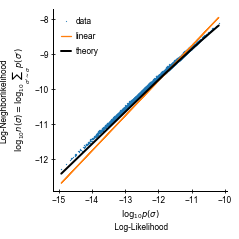

In [11]:
fig, ax = plt.subplots(figsize=(3.42, 3.42))
ax.plot(np.log10(psigmas), np.log10(nsigmas), '.', label='data', ms=1)
ax.plot(np.log10(psigmas), np.log10(psigmas)+np.log10(k*(S-1)), '-', label='linear')
#factor = 20
#psigmas_theory = np.linspace(S**(-k)/factor, factor*S**(-k))
psigmas_theory = np.linspace(min(psigmas), max(psigmas))
ax.plot(np.log10(psigmas_theory),
        #np.log10(psigmas_theory) + np.log10(Nn - S*(psigmas_theory*float(S**k) - 1)),
        np.log10(psigmas_theory) + np.log10(Nn - S*np.log(psigmas_theory*N)),
        'k-', label='theory', lw=2)
#ax.axvline(-k*np.log10(S), c='k')
ax.set_xlabel('$\log_{10} p(\sigma)$\n Log-Likelihood')
ax.set_ylabel("Log-Neighborlikelihood\n $\log_{10} n(\sigma) = \log_{10} \sum_{\sigma' \sim \sigma} p(\sigma')$")
ax.legend()
fig.tight_layout()
fig.savefig('main.png')
fig.savefig('../../paper/images/nnproblikelihood.pdf')

slope, intercept = np.polyfit(np.log10(psigmas), np.log10(nsigmas), 1)
rho1 = 1 - S/(k*(S-1))
print('slope, prediction', slope, rho1)
nsigmavar_pred = np.var(psigmas)* Nn**2 * rho1**2
nsigmavar_pred2 = Nn*np.var(psigmas)*(1+(Nn-1)*rhop)
print('nsigmavar (sampled, upper, pred):',
      np.var(nsigmas),
      np.var(psigmas)*Nn**2,
      nsigmavar_pred,
      nsigmavar_pred2)
nsigmabar = np.mean(nsigmas*psigmas)*N
nsigmabar_upper = Nn*np.mean(psigmas**2)*N
nsigmabar_pred = Nn/N + N*Nn*rho1*np.var(psigmas)
nsigmabar_pred2 = Nn/N + N*(Nn-1.5*S)*np.var(psigmas)
nsigmabar_pred3 = Nn/N + N*(np.var(psigmas) * nsigmavar_pred2)**.5
print('nsigmabar (lower, sampled, upper):', Nn/N, nsigmabar, nsigmabar_upper)
print('prediction (-S, -3/2S, rhop)', nsigmabar_pred, nsigmabar_pred2, nsigmabar_pred3)

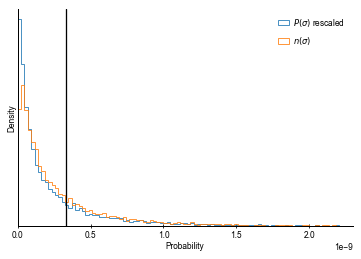

In [12]:
bins = np.linspace(0.0, np.percentile(nsigmas, 99), 100)
fig, ax = plt.subplots()
histkwargs = dict(bins=bins, histtype='step')
ax.hist(psigmas*k*(S-1), label='$P(\sigma)$ rescaled', **histkwargs)
ax.hist(nsigmas, label='$n(\sigma)$', **histkwargs)
ax.legend()
ax.axvline(1/S**k * k*(S-1), c='k')
ax.set_xlim(min(bins), max(bins))
ax.set_yticks([])
ax.set_ylabel('Density')
ax.set_xlabel('Probability');

# resampling

In [29]:
S = 20
k = 9

Nn = k*(S-1)
N = float(S**k)

sigma_lognormal = 0.3
pi = np.random.lognormal(sigma=sigma_lognormal, size=S)
pi /= pi.sum()

In [30]:
nsigmabars = []
for i in range(100):
    psigmas = []
    nsigmas = []
    Nsample = 10000
    for i in range(Nsample):
        sigma = np.random.randint(0, S, k)
        psigma = np.prod(pi[sigma])
        nsigma = np.prod(pi[sigma])*np.sum((1-pi[sigma])/pi[sigma])
        psigmas.append(psigma)
        nsigmas.append(nsigma)
    nsigmas = np.asarray(nsigmas)
    psigmas = np.asarray(psigmas)
    nsigmabar = np.mean(nsigmas*psigmas)*N
    nsigmabars.append(nsigmabar)


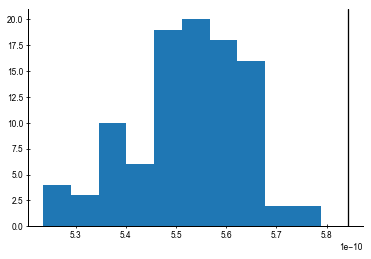

In [31]:
plt.hist(nsigmabars)
p0 = 1/N
cv = (np.exp(np.var(np.log(pi))*k)-1)**.5
predicted = p0 * Nn * (1.0 +  cv**2 * (1-1.5* S/Nn))
plt.axvline(predicted, c='k')

In [118]:
S = 20
k = 9

Nn = k*(S-1)
N = float(S**k)

empmeans = []
empstds = []
predicts =[]
varpis = []
for j, sigma_lognormal in enumerate(np.logspace(-2.5, np.log(0.9), 10)):
    pi = np.random.lognormal(sigma=sigma_lognormal, size=S)
    pi /= pi.sum()

    nsigmabars = []
    Nrepeat = 100
    for i in range(Nrepeat):
        psigmas = []
        nsigmas = []
        Nsample = 1000
        for i in range(Nsample):
            sigma = np.random.randint(0, S, k)
            psigma = np.prod(pi[sigma])
            nsigma = np.prod(pi[sigma])*np.sum((1-pi[sigma])/pi[sigma])
            psigmas.append(psigma)
            nsigmas.append(nsigma)
        nsigmas = np.asarray(nsigmas)
        psigmas = np.asarray(psigmas)
        nsigmabar = np.mean(nsigmas*psigmas)*N
        nsigmabars.append(nsigmabar)
    cv = (np.exp(np.var(np.log(pi))*k)-1)**.5
    predicted = p0 * Nn * (1.0 +  cv**2 * (1-1.5* S/Nn))
    empmeans.append(np.mean(nsigmabars))
    empstds.append(np.std(nsigmabars))
    predicts.append(predicted)
    varpis.append(np.var(np.log(pi)))

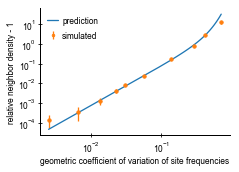

In [121]:
fig, ax = plt.subplots(figsize=(3.42, 2.5))
varpis_theory = np.linspace(min(varpis), max(varpis))
cv = (np.exp(varpis_theory*k)-1)**.5
predicted = p0 * Nn * (1.0 +  cv**2 * (1-1.5*S/Nn))
ax.plot((np.exp(varpis_theory)-1)**.5, predicted*N/Nn-1, '-', label='prediction')
ax.errorbar((np.exp(np.array(varpis))-1)**.5, np.array(empmeans)*N/Nn-1, 2*np.array(empstds)/Nrepeat**.5*N/Nn, fmt='o', label='simulated')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.ylabel(r'relative neighbor density - 1')
plt.xlabel(r'geometric coefficient of variation of site frequencies')
fig.tight_layout()
fig.savefig('neighborprobability.png')

# Neighbors from different distribution

In [304]:
sigma_lognormal = 1.0
pi = np.random.lognormal(sigma=sigma_lognormal, size=S)
pi /= pi.sum()

In [337]:
dpi = np.random.lognormal(sigma=0.5, size=S)
pi2 = pi*dpi
pi2 /= pi2.sum()

In [123]:
df = Counter(human, 1).to_df(norm=True, clean=True)
df.sort_values('seq', inplace=True)
pi = np.asarray(df['freq'])
pi

array([0.07012693, 0.02305051, 0.0473157 , 0.07101057, 0.0365297 ,
       0.06577845, 0.02626757, 0.04330068, 0.05724314, 0.09970845,
       0.02132759, 0.03584496, 0.06314819, 0.04767035, 0.05643573,
       0.08332527, 0.05347764, 0.05963846, 0.01217275, 0.02662735])

In [185]:
df = Counter(proteome_path('CMV'), 1).to_df(norm=True, clean=True)
df.sort_values('seq', inplace=True)
pi2 = np.asarray(df['freq'])
pi2

array([0.07841523, 0.02543691, 0.04814408, 0.05226157, 0.03913136,
       0.06177753, 0.03239089, 0.03522738, 0.0298289 , 0.10188489,
       0.02023668, 0.03222314, 0.06128954, 0.03547138, 0.08161771,
       0.07588373, 0.06789276, 0.07445024, 0.01390795, 0.03252814])

In [188]:
Nsample = 100000
psigmas = []
p2sigmas = []
nsigmas = []
n2sigmas = []
for i in range(Nsample):
    sigma = np.random.randint(0, S, k)
    psigma = np.prod(pi[sigma])
    nsigma = np.prod(pi[sigma])*np.sum((1-pi[sigma])/pi[sigma])
    p2sigma = np.prod(pi2[sigma])
    n2sigma = np.prod(pi2[sigma])*np.sum((1-pi2[sigma])/pi2[sigma])
    psigmas.append(psigma)
    p2sigmas.append(p2sigma)
    nsigmas.append(nsigma)
    n2sigmas.append(n2sigma)
psigmas = np.array(psigmas)
p2sigmas = np.array(p2sigmas)
nsigmas = np.array(nsigmas)
n2sigmas = np.array(n2sigmas)

0.7913977897096637

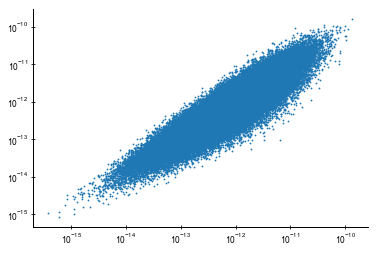

In [189]:
plt.plot(np.array(psigmas), np.array(p2sigmas), 'o', ms=1)
plt.xscale('log')
plt.yscale('log')
np.corrcoef(psigmas, p2sigmas)[0, 1]

In [196]:
np.mean(psigmas*n2sigmas)*N/(Nn/N), np.mean(psigmas*nsigmas)*N/(Nn/N), np.mean(p2sigmas*n2sigmas)*N/(Nn/N)

(3.724899792702455, 4.123023237427103, 4.662227304409363)

In [210]:
np.mean(np.log(pi2/pi))

-0.0057572107868609414

In [207]:
k * np.var(pi2/pi-1), k*np.var(np.log(pi2/pi))

(0.4074057104108117, 0.4713946807340225)

In [209]:
np.var(np.log(p2sigmas[np.abs((psigmas-1e-12)/psigmas)<0.02]))

0.44364034581030587

## TODO

- What about longer distances? (Second, third neighbours etc.?) Do things generalize?
- Test with rough Mount Fuji?